In [5]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pmdarima as pm 
from pmdarima import model_selection 
from sklearn.metrics import mean_squared_error 
from math import sqrt 
import pmdarima as pm 
from pmdarima import model_selection 
import statsmodels.api as sm 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Data management

In [38]:
file_P = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_P)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.reset_index(drop=True)

# Convert the 'HourUTC' column to datetime if it's not already
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])

# Set the start and end dates
start_date = pd.Timestamp('2023-10-01 00:00:00')
end_date = pd.Timestamp('2023-12-31 23:00:00')

# Filter the data and reset indec
prices = df_prices
df_prices = df_prices[(df_prices['HourUTC'] >= start_date) & (df_prices['HourUTC'] <= end_date)]
df_prices = df_prices.reset_index(drop=True)

# Split data into training and testing sets
data = df_prices[(df_prices['HourUTC'].dt.date >= start_date.date()) & (df_prices['HourUTC'].dt.date <= end_date.date())]
data = data['SpotPriceDKK'].values
train, test = model_selection.train_test_split(data, test_size=744) # 744 hours in december

# Task 1

#### Plot values of test and train and test seasonality

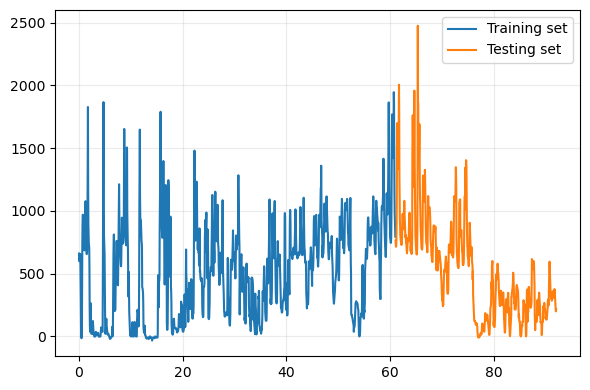

744
1464


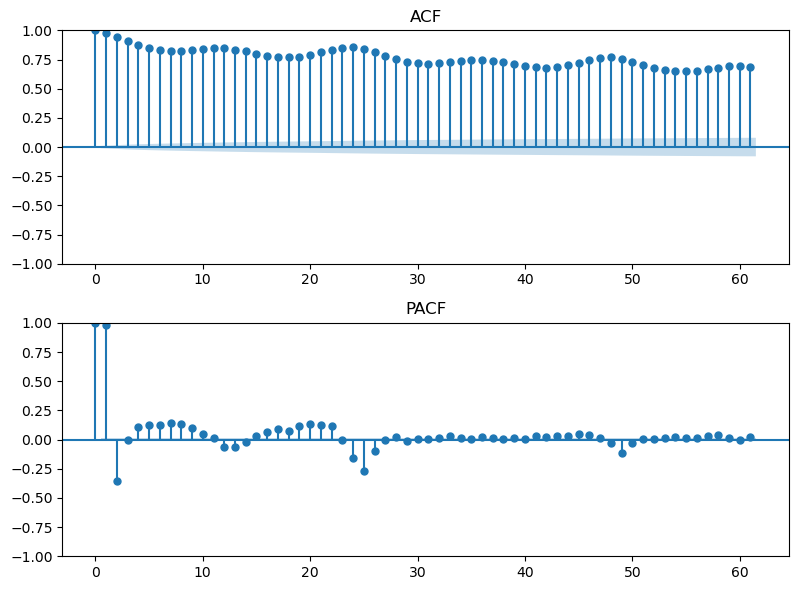

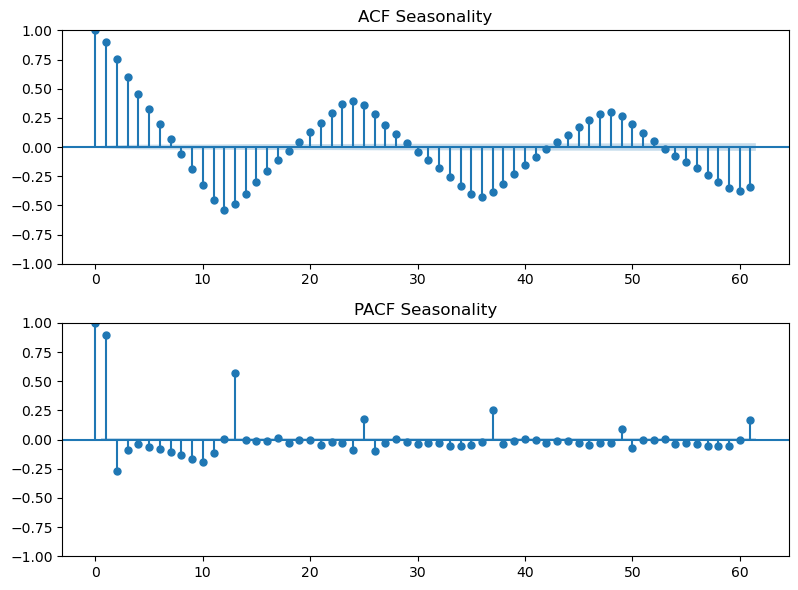

In [39]:
n_train = len(train)
n_test = len(test)
n_data = len(data)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1,n_train+1)/24, train)
plt.plot(np.arange(n_train+1,n_data+1)/24, test)
plt.legend(["Training set", "Testing set"])
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


print(n_test)
print(n_train)



# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Determine lag for ACF/PACF plots
lag = 12*5+1

# Check ACF plot
sm.graphics.tsa.plot_acf(prices["SpotPriceDKK"], title = "ACF", lags=lag, ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(prices["SpotPriceDKK"], title = "PACF", lags=lag, ax=ax[1])

plt.tight_layout()
plt.show()
# from the previously plot a seasonal pattern is observed, thus we will take the difference of the data with a lag of 12
prices12 = pm.utils.diff(prices["SpotPriceDKK"],12)

# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Check ACF plot
sm.graphics.tsa.plot_acf(prices12, lags=lag, title="ACF Seasonality", ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(prices12, lags=lag, title="PACF Seasonality", ax=ax[1])

plt.tight_layout()
plt.show()

# Task 1.1

#### Find ARIMA model

In [40]:
#m_noS = pm.auto_arima(train, trace = True, seasonal = False)
m_S = pm.auto_arima(train, trace = True, seasonal=True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=18125.929, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=17934.451, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=17927.556, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=18123.930, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=17926.948, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=17927.035, Time=0.32 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=17923.456, Time=0.26 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=17923.778, Time=0.56 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=17924.247, Time=0.58 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=17933.776, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=17849.822, Time=0.85 sec
 ARIMA(2,1,1)(1,0,0)[12

### Create 1-day predictions

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


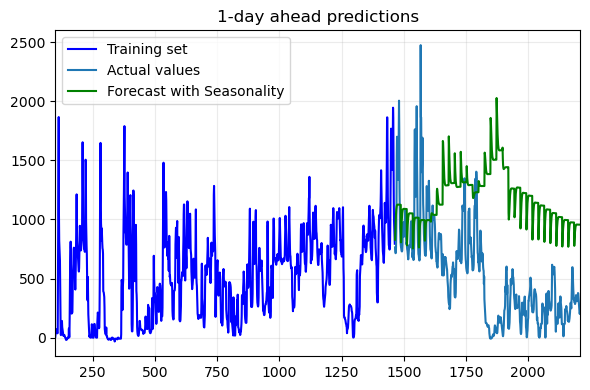

In [41]:
### 1-day predictions ###


# Create an empty list for the day ahead forecasts
Forecasts_S = []
#Forecasts_noS = []

for i in range(31):

    # Generate forecast for the next 24-hour period
    frc_S = m_S.predict(n_periods=24)
    #frc_noS = m_noS.predict(n_periods=24)
    
    # Divide the 24-hour forecast by 24 to get the forecast for each hour
    frc_S_per_hour = frc_S
    #frc_noS_per_hour = frc_noS
    
    # Append the forecast for each hour to the list
    Forecasts_S.extend(frc_S_per_hour)
    #Forecasts_noS.extend(frc_noS_per_hour)
    
    # Update the model with new observations (24-hour period)
    m_S.update(test[i])  # Update with 24 observations
    #m_noS.update(test[i])  # Update with 24 observations

    print(i)



plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1,n_train+1), train, color = 'blue')
plt.plot(np.arange(n_train+1,n_data+1), test)
plt.plot(np.arange(n_train+1,n_train+1+len(Forecasts_S)), Forecasts_S, color = 'green')
#plt.plot(np.arange(n_train+1,n_train+1+len(Forecasts_noS)), Forecasts_noS, color = 'purple')
plt.title("1-day ahead predictions")
plt.legend(["Training set", "Actual values", "Forecast with Seasonality"])
plt.xlim(100, n_data)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

### Persistence

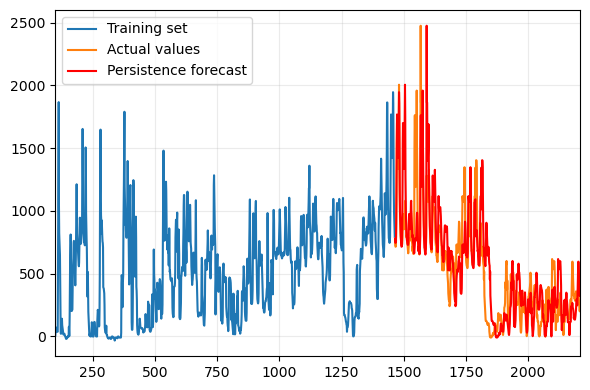

In [42]:
Persistence = []

for i in range(len(test)):
   Persistence.extend(data[len(train)+i*24-24:len(train)+i*24])
   

Persistence = Persistence[:len(test)]

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1, n_train + 1), train)
plt.plot(np.arange(n_train + 1, n_data + 1), test)
plt.plot(np.arange(n_train + 1, n_data + 1), Persistence, color='red')
plt.legend(["Training set", "Actual values", "Persistence forecast"])
plt.xlim(100, n_data)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


### RMSE

In [43]:
# Calculate the RMSE for the seasonal, non-seasonal and persistence forecasts
RMSE_S = sqrt(mean_squared_error(test, Forecasts_S))
#RMSE_noS = sqrt(mean_squared_error(test, Forecasts_noS))
RMSE_Persistence = sqrt(mean_squared_error(test, Persistence))

print("RMSE for the seasonal forecast: ", RMSE_S)
#print("RMSE for the non-seasonal forecast: ", RMSE_noS)
print("RMSE for the persistence forecast: ", RMSE_Persistence)

RMSE for the seasonal forecast:  809.3143377862241
RMSE for the persistence forecast:  248.88782621366917


# Task 1.2

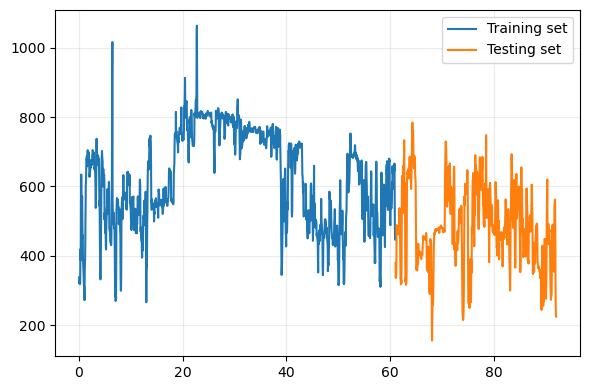

In [55]:
## Using central power data to predict spot prices
# Set the start and end dates
start_date = pd.Timestamp('2023-10-01 00:00:00')
end_date = pd.Timestamp('2023-12-31 23:00:00')

file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data[df_data['PriceArea'] == 'DK2']
df_data = df_data.reset_index(drop=True)

# Filter the data and reset indec
data = df_data[(df_prices["HourUTC"] >= start_date) & (df_data["HourUTC"] <= end_date)]
data = data[(df_prices["HourUTC"].dt.date >= start_date.date()) & (df_prices["HourUTC"].dt.date <= end_date.date())]
data = data.reset_index(drop=True)

CentralPowerMWH = data['CentralPowerMWh'].values
centraltrain, centraltest = model_selection.train_test_split(CentralPowerMWH, test_size=744)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1,n_train+1)/24, centraltrain)
plt.plot(np.arange(n_train+1,n_data+1)/24, centraltest)
plt.legend(["Training set", "Testing set"])
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


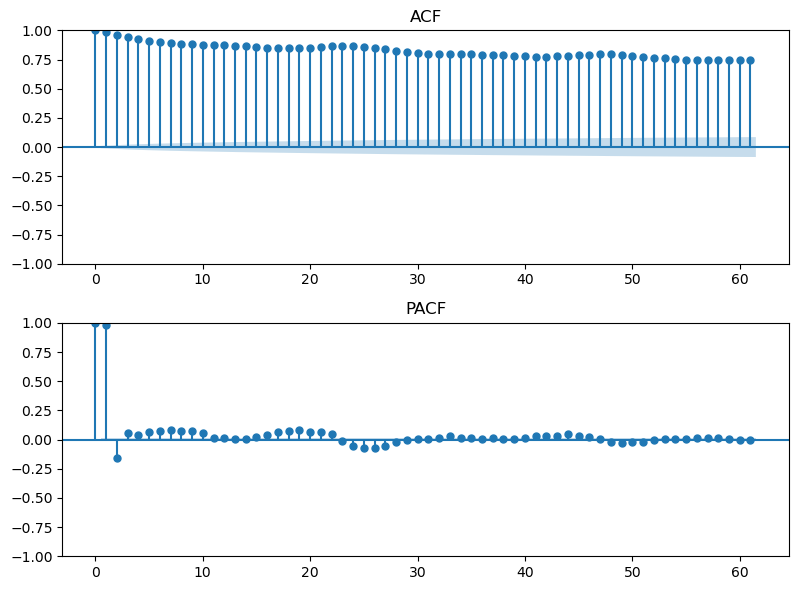

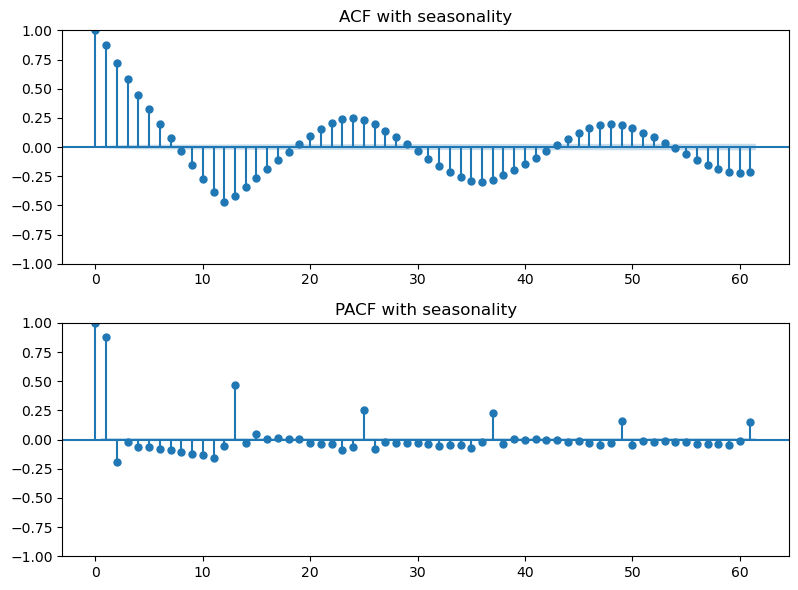

In [56]:

# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Determine lag for ACF/PACF plots
lag = 12*5+1

# Check ACF plot
sm.graphics.tsa.plot_acf(df_data["CentralPowerMWh"], title = "ACF", lags= lag, ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(df_data["CentralPowerMWh"], title = "PACF", lags= lag, ax=ax[1])

plt.tight_layout()
plt.show()

# from the previously plot a seasonal pattern is observed, thus we will take the difference of the data with a lag of 12
centraltrain12 = pm.utils.diff(df_data["CentralPowerMWh"],12)

# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Check ACF plot
sm.graphics.tsa.plot_acf(centraltrain12, lags=lag, title="ACF with seasonality", ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(centraltrain12, lags=lag, title="PACF with seasonality", ax=ax[1])

plt.tight_layout()
plt.show()


In [57]:

Central_S = pm.auto_arima(centraltrain, trace = True, seasonal=True, m = 12)
#Central_noS = pm.auto_arima(centraltrain, trace = True, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14579.476, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=14527.518, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=14523.506, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=14577.486, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=14522.611, Time=0.42 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=14523.282, Time=0.83 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=14524.263, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=14524.238, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=14526.874, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=14464.654, Time=0.96 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=14465.977, Time=1.77 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=14466.104, Time=1.98 sec
 ARIMA(1,1,2)(1,0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


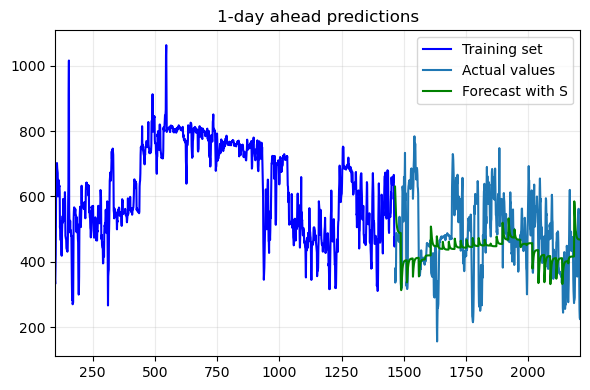

In [63]:

Central_Forecasts_S = []
#Central_Forecasts_noS = []

for i in range(31):
        
            # Generate forecast for the next 24-hour period
            frc_S = Central_S.predict(n_periods=24)
            #frc_noS = Central_noS.predict(n_periods=24)
            
            # Divide the 24-hour forecast by 24 to get the forecast for each hour
            frc_S_per_hour = frc_S
            #frc_noS_per_hour = frc_noS
            
            # Append the forecast for each hour to the list
            Central_Forecasts_S.extend(frc_S_per_hour)
            #Central_Forecasts_noS.extend(frc_noS_per_hour)
            
            # Update the model with new observations (24-hour period)
            Central_S.update(centraltest[i])  # Update with 24 observations
            #Central_noS.update(centraltest[i])  # Update with 24 observations
        
            print(i)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1,n_train+1), centraltrain, color = 'blue')
plt.plot(np.arange(n_train+1,n_data+1), centraltest)
#plt.plot(np.arange(n_train+1,n_train+1+len(Central_Forecasts_noS)), Central_Forecasts_noS, color = 'purple')
plt.plot(np.arange(n_train+1,n_train+1+len(Central_Forecasts_S)), Central_Forecasts_S, color = 'green')
plt.title("1-day ahead predictions")
plt.legend(["Training set", "Actual values", "Forecast with S"])
plt.xlim(100, n_data)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


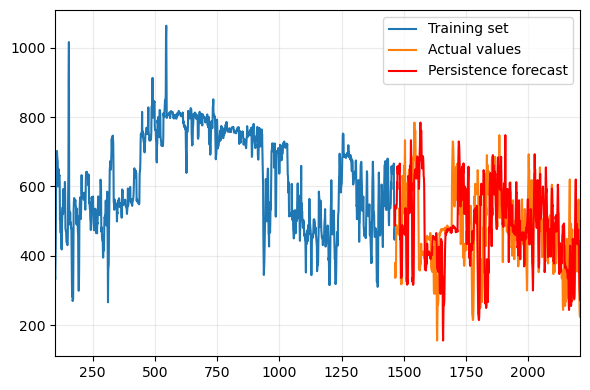

In [70]:

CentralPersistence = []

for i in range(len(centraltest)):
   
   if i == 0:
      daily_persistence = centraltrain[-24:]  # For the first day, use the last 24 hours of training data
   else:
      daily_persistence = centraltest[(i - 1) * 24:i * 24]  # Select the last 24 hours of the previous day
   
   CentralPersistence.extend(daily_persistence)

CentralPersistence = CentralPersistence[:len(centraltest)]

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1, n_train + 1), centraltrain)
plt.plot(np.arange(n_train + 1, n_data + 1), centraltest)
plt.plot(np.arange(n_train + 1, n_data + 1), CentralPersistence, color='red')
plt.legend(["Training set", "Actual values", "Persistence forecast"])
plt.xlim(100, n_data)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


In [71]:

# Calculate the RMSE for the seasonal, non-seasonal and persistence forecasts
CentralRMSE_S = sqrt(mean_squared_error(centraltest, Central_Forecasts_S))
#CentralRMSE_noS = sqrt(mean_squared_error(centraltest, Central_Forecasts_noS))
CentralRMSE_Persistence = sqrt(mean_squared_error(centraltest, CentralPersistence))

print("RMSE for the seasonal forecast: ", CentralRMSE_S)
#print("RMSE for the non-seasonal forecast: ", CentralRMSE_noS)
print("RMSE for the persistence forecast: ", CentralRMSE_Persistence)

RMSE for the seasonal forecast:  125.21984241490203
RMSE for the persistence forecast:  126.86532282073223


# Task 2

## Task 2.1

Epoch 1/30


c:\Users\willi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0262 - val_loss: 0.0038
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - val_loss: 0.0024
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - val_loss: 0.0012
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - val_loss: 0.0014
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - val_loss: 9.6385e-04
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 7.8150e-04
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 7.8706e-04
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 5.2659e-04
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 7.4856e-04
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 5.7049e-04
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 

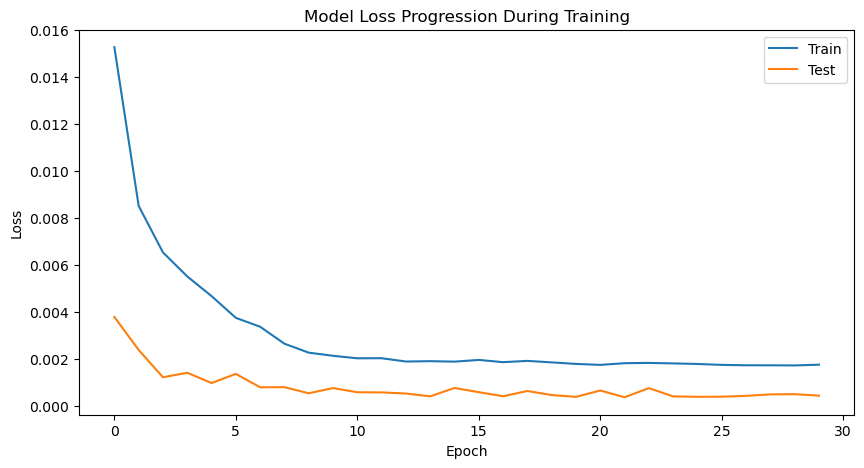

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_prices['SpotPriceDKK'] = scaler.fit_transform(df_prices[['SpotPriceDKK']])

# Define a function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    data = data.values  # Ensure 'data' is a NumPy array
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 24  # Using 24 hours of data to predict the next hour
X, y = create_sequences(df_prices['SpotPriceDKK'], sequence_length)

# Splitting data into training and testing sets
train_size = int(len(X) * 0.9)  # 90% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# X_train and X_test for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Building the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True),  
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model using RMSE
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Test RMSE: ", rmse)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Task 2.2

Epoch 1/30


c:\Users\willi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0237 - val_loss: 0.0030
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0033
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - val_loss: 0.0021
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - val_loss: 0.0018
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - val_loss: 9.3984e-04
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027 - val_loss: 8.4561e-04
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 5.5689e-04
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018

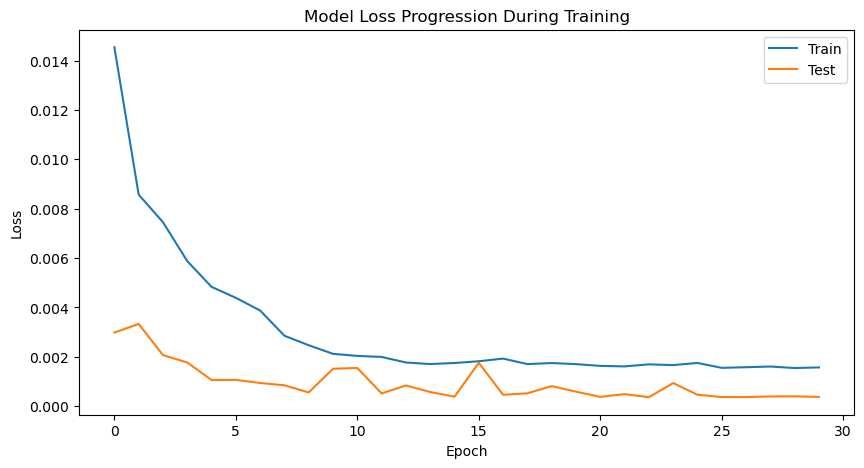

In [19]:
# Adjusting column names according to the data
df_data= df_data[df_data['PriceArea'] == 'DK2']

df_data['DayOfWeek'] = df_data['HourUTC'].dt.dayofweek  # Adding day of the week as an exogenous variable
df_data = df_data[['HourUTC', 'OffshoreWindGe100MW_MWh', 'OnshoreWindGe50kW_MWh', 'SolarPowerGe40kW_MWh', 'DayOfWeek']]

df_merged = pd.merge(df_prices, df_data, on='HourUTC')

# Normalizng
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['SpotPriceDKK', 'OffshoreWindGe100MW_MWh', 'OnshoreWindGe50kW_MWh', 'SolarPowerGe40kW_MWh', 'DayOfWeek']

df_merged[features] = scaler.fit_transform(df_merged[features])

# Define a function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    data = data.to_numpy()  # Convert DataFrame to numpy array for processing
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Creating sequence
sequence_length = 24
X, y = create_sequences(df_merged[features], sequence_length)

# Splitting data into training and testing sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Checing the input shape is correctly specified
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

# Rebuild the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and calculate RMSE
predictions = model.predict(X_test)
rmse_exogenous = np.sqrt(mean_squared_error(y_test, predictions))
print("Test RMSE with Exogenous Variables: ", rmse_exogenous)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Task 4

### Combine the forecasting tool that predicts for the next 24 hours you developed with the optimization tool for the optimal bidding strategy for batteries you developed in Assignment 1, and calculate the total profits for the whole month of December 2023.

In [20]:
##  The battery has a 50% SOC at the start of your simulation (on December 1st).
##  Each day you optimize the schedule of the battery between 00:00 and for the next 24 hours.
##  You buy and sell energy at the spot price (do not consider any taxes or tariffs).

##  You can decide what your state of charge constraint at the end of each daily optimization is.
##  Remember that the final SOC of day N is the starting SOC of day N+1! Mind that on the first
##  day the SOC is set to 50% (initial SOC on December 1) and you should choose the same strategy
##  for the whole period.

##  The choice of the final SOC constraint must be justified using your training dataset and not your
##  testing dataset! You should design a strategy based on available data and not tailor your strategy
##  based on the testing dataset!


params = {
    'Pmax': 5, #Max charging capacity 1 MW
    'n_c': 0.95, #Charging effiency
    'n_d': 0.95, #Decharging effiency
    'Cmax': 10 #Max 2 MWh storage
}

params['C_0'] = 0.5 * params['Cmax'] #SOC at start
params['C_n'] = 0.5 * params['Cmax'] #SOC at end


## Task 4.1

### Calculate the profits you achieve during the testing dataset by using the bidding model from Assignment 1 and perfect knowledge of prices (you performed this task in Assignment 1)

In [21]:

#Convert prices to DKK/kWh
df_prices["SpotPriceDKK"] = df_prices["SpotPriceDKK"]/1000

## import the cvxpy library
import cvxpy as cp

## Define the optimizer function

def Optimizer(params, p):

    import cvxpy as cp

    n = len(p)
    p_c = cp.Variable(n)
    p_d = cp.Variable(n)
    X   = cp.Variable(n)
    profit = cp.sum(p_d@p - p_c@p)
    
    constraints = [p_c >= 0, 
                   p_d >= 0, 
                   p_c <= params['Pmax'], 
                   p_d <= params['Pmax']]
    constraints += [X >= 0, X <= params['Cmax']]
    constraints += [X[0]==params['C_0'] + p_c[0]*params['n_c'] - p_d[0]/params['n_d']]
    
    constraints += [X[1:] == X[:-1] + p_c[1:]*params['n_c'] - p_d[1:]/params['n_d']]
    
    constraints += [X[n-1]>=params['C_n']]
    
    problem = cp.Problem(cp.Maximize(profit), constraints)
    problem.solve(solver=cp.ECOS)
    
    return profit.value, p_c.value, p_d.value, X.value

# Convert prices to DKK/kWh
test = test/1000
profitOpt, p_cOpt, p_dOpt, XOpt = Optimizer(params, test)

print("Profit using battery in december using actual values is:", profitOpt, ",DKK")

Profit using battery in december using actual values is: 137.91642501644026 ,DKK


### Next, use the forecasting model you developed and has the highest accuracy (ARIMA or LSTM) for day-ahead prediction, and use the forecasted prices instead of the actual ones to bid. 

In [22]:
## We use ARIMA model m_S to predict the spot prices for the month of December 2023 and calculate the profit

# Convert prices to DKK/kWh
Forecasts_S = np.array(Forecasts_S)
Forecasts_S = Forecasts_S/1000

profitOpt, p_cOpt, p_dOpt, XOpt = Optimizer(params, Forecasts_S)
print("Profit using battery in december using forecasted values is:", profitOpt, ",DKK")

## Now also use the LSTM model and compare the results

# .............................................

Profit using battery in december using forecasted values is: 41.83857942094062 ,DKK


### Compare the profits you achieve with your forecasting model with the ones you achieve with perfect price knowledge. What do you observe?

In [23]:
print("Ádd something here")

Ádd something here


## Task 4.2

### Use the persistence model for day-ahead predictions you established in task 1.1 to forecast electricity prices, and use those to calculate your profits from optimizing the battery.

In [24]:
## Now we use the persistence data to predict the profit from optimizing the battery

# Convert prices to DKK/kWh
CentralPersistence = np.array(CentralPersistence)
CentralPersistence = CentralPersistence/1000

profitOpt, p_cOpt, p_dOpt, XOpt = Optimizer(params, CentralPersistence)
print("Profit using battery in december using persistence forecast is:", profitOpt, ",DKK")

Profit using battery in december using persistence forecast is: 542.4504676160522 ,DKK


### Compare the profits you obtain from persistence forecasting with the profits you calculated in task 4.1 (perfect knowledge and forecasts via ARIMA or LSTM). Discuss the results and what is the added value of your forecaster, compared to simply using persistence.

In [25]:
print("Add something here")

Add something here


## Task 4.3

### Do this in overleaf

##